**This notebook shows how to read from a "zarr" dataset, which has been "chunked" (broken into a little bits) in a way that makes grabbing a time series from a single point very quickly.**

The essence is that while the original data was many raster files, each file representing imagery from a single timestamp, the "zarr" dataset is stored in time series, so there is a single file for each pixel and all the values in time belonging to that pixel (actually, the files are 3x3 pixels).

In [1]:
import xarray as xr

import glob
import os
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

from dask.distributed import Client, LocalCluster


In [7]:
# Because plot_shoreline.py is in a directory above where this notebook is, we need to import the sys module and add the path to the parent directory to the path list
import sys
sys.path.append('..')
from plot_shoreline import plot_from_globe_shoreline

In [15]:
bounds = (-125, 46, -122, 49)
shoreline = plot_from_globe_shoreline(bounds)

### Start a Dask Cluster 

In [3]:
# Create a Dask cluster so we can watch the dask dashboard
workers = 6
ip_addres = 'http://j-lundquist-3.ce.washington.edu'
port=':8787'
threads = 2
cluster = LocalCluster(n_workers=workers, threads_per_worker=threads, dashboard_address=port)
client = Client(cluster)

### Open all raster files from zarr

In [8]:
zarr_path = '/storage/GOES/orthorectified/Fog2022_withtime.zarr'
ds = xr.open_dataset(
    zarr_path,
    chunks={'time': 40785, 'latitude': 50, 'longitude': 50},
    engine='zarr'
)
# When we pass in a chunks argument, the dataset opened will be filled with Dask arrays

/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "latitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [9]:
ds

<xarray.Dataset>
Dimensions:      (time: 40785, latitude: 284, longitude: 284)
Coordinates:
  * latitude     (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude    (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0
  * time         (time) datetime64[ns] 2022-04-30T17:01:17 ... 2022-09-30T16:...
Data variables:
    Height       (time, latitude, longitude) float32 dask.array<chunksize=(40785, 50, 50), meta=np.ndarray>
    spatial_ref  (time) int64 dask.array<chunksize=(40785,), meta=np.ndarray>
    time (UTC)   (time) datetime64[ns] dask.array<chunksize=(40785,), meta=np.ndarray>

In [ ]:
bounds = ds.rio.bounds()
shoreline = plot_shoreline(bounds)

In [11]:
ds['Height']

<xarray.DataArray 'Height' (time: 40785, latitude: 284, longitude: 284)>
dask.array<open_dataset-528873863c4af07a5d2ef649a554af0eHeight, shape=(40785, 284, 284), dtype=float32, chunksize=(40785, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0
  * time       (time) datetime64[ns] 2022-04-30T17:01:17 ... 2022-09-30T16:51:17
Attributes:
    coordinates:   dem_px_angle_y dem_px_angle_x
    grid_mapping:  spatial_ref

In [ ]:
# ds['FLCC'] = (ds['Height'] > 2000).astype(int)
ds['Height'][40000][140].values

### Get the datetimes from the file names to replace the time index in the dataset
because zarr has a bug that does not allow it to save `datetime64[ns]` objects correctly (precision is lost for hours and minutes)

In [10]:
image_folder = '/storage/GOES/orthorectified/Fog2022_withtime/'
files = glob.glob(os.path.join(image_folder, "*_o.nc"))
files[0] # Take a look at the path of one file

'/storage/GOES/orthorectified/Fog2022_withtime/OR_ABI-L2-ACHAC-M6_G17_s20222440001177_e20222440003550_c20222440007138_o.nc'

In [11]:
datetimes = [
    dt.datetime.strptime(
        f.split('_')[4][1:-1], # parse the start time (the part "s2022__________" in the file name)
        "%Y%j%H%M%S"
    ) for f in files
]
''' The files in zarr are already sorted chronologically, 
but the files in the image_folder directory are not, 
so the datetimes info parsed from the directory also have to be sorted.'''
datetimes = sorted(datetimes)

In [12]:
ds['time'] = datetimes

In [12]:
# Take a look at the datetime objects
# pd.to_datetime(ds['time'])

## Frequency when NaNs are ignored

In [23]:
# We choose 2000 meters as the threshold for cloud top height to be considered fog or low cloud
ds['FLCC'] = (ds['Height'] < 2000) # Create a new array for ds which has 1s where Height is < 400 meters and 0s otherwise. NaN values are also represented as 0s here.
nan_indices = ds['Height'].isnull() # xarray's isnull() returns a boolean array indicated which item in ds['Height] has a missing value
'''Filter the array: keep the items that pass the condition. The items which don't pass will be replaced with NaNs.
This is xarray's where(), very different from numpy's where(). '''
not_nan_indices = ~nan_indices
ds['FLCC'] = ds['FLCC'].where(not_nan_indices) # Change the False values in FLCC which were originally NaNs in Height back to NaNs in FLCC

In [ ]:
# sanity check to see if we are computing the values related to NaNs correctly
nans = (nan_indices == 1).sum().values
not_nans = (not_nan_indices == 1).sum().values
total_pixels = 284*284*40785
print(nans, not_nans, total_pixels)
print('Expecting 0, get: ', total_pixels - (nans + not_nans))

In [ ]:
ds['time'].size

40785

In [ ]:
(~ds['Height'].isnull()).sum().values # number of pixels that are not NaNs

array(78338460)

In [24]:
ds['not_nans'] = ~ds['Height'].isnull()

In [25]:
FLCC_freq = (
    # ds['FLCC'].sum(dim='time') / ds['time'].size
    ds['FLCC'].sum(dim='time') / ds['not_nans'].sum(dim='time')
)
# Because we are working with Dask arrays in this dataset, frequency data won't actually be calculated until .load() is called in the cell below. The output of this cell is just a preview of what FLCC_freq will look like.

In [26]:
# We call load to get this in memory right away - then plotting doesn't take a long time.
FLCC_freq.load()

<xarray.DataArray (latitude: 284, longitude: 284)>
array([[0.23759719, 0.23759719, 0.23759719, ..., 0.09057698, 0.09057698,
        0.09057698],
       [0.23759719, 0.23759719, 0.23759719, ..., 0.09057698, 0.09057698,
        0.09057698],
       [0.23759719, 0.23759719, 0.23759719, ..., 0.09057698, 0.09057698,
        0.09057698],
       ...,
       [0.58344401, 0.58344401, 0.58344401, ..., 0.10865664, 0.10865664,
        0.10865664],
       [0.58344401, 0.58344401, 0.58344401, ..., 0.10865664, 0.10865664,
        0.10865664],
       [0.58344401, 0.58344401, 0.58344401, ..., 0.10865664, 0.10865664,
        0.10865664]])
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

In [27]:
FLCC_freq.max()

<xarray.DataArray ()>
array(0.58843239)

Text(0.5, 1.0, 'Fog and low clouds under 2000m\nFrequency\nMay-Sep 2022\nNaNs ignored')

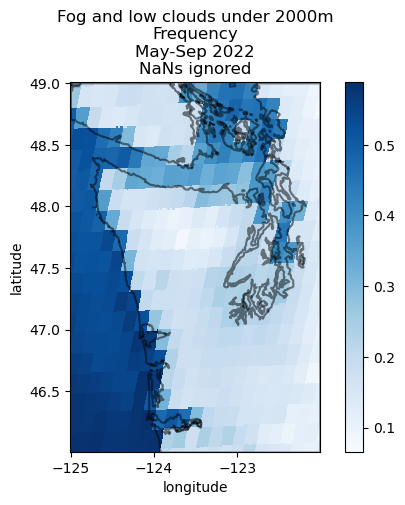

In [28]:
fig, ax = plt.subplots()

FLCC_freq.plot(ax = ax, cmap = 'Blues')
shoreline.plot(ax = ax, color = "black", alpha = 0.5) # how to make the stroke of the shoreline thinner?
plt.title('Fog and low clouds under 2000m\nFrequency\nMay-Sep 2022\nNaNs ignored')

## Frequency when NaNs are not ignored

### Fog low cloud frequency, with NaNs not ignored but counted as clear sky

In [32]:
# For calculating frequency of fog or low clouds
ds['FLCC'] = (ds['Height'] < 2000).astype(int)
FLCC_freq = (
    ds['FLCC'].sum(dim='time') / ds['time'].size
)

In [33]:
FLCC_freq.load()

<xarray.DataArray 'FLCC' (latitude: 284, longitude: 284)>
array([[0.16932696, 0.16932696, 0.16932696, ..., 0.05896776, 0.05896776,
        0.05896776],
       [0.16932696, 0.16932696, 0.16932696, ..., 0.05896776, 0.05896776,
        0.05896776],
       [0.16932696, 0.16932696, 0.16932696, ..., 0.05896776, 0.05896776,
        0.05896776],
       ...,
       [0.49545176, 0.49545176, 0.49545176, ..., 0.06235135, 0.06235135,
        0.06235135],
       [0.49545176, 0.49545176, 0.49545176, ..., 0.06235135, 0.06235135,
        0.06235135],
       [0.49545176, 0.49545176, 0.49545176, ..., 0.06235135, 0.06235135,
        0.06235135]])
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

In [35]:
FLCC_freq.max()

<xarray.DataArray 'FLCC' ()>
array(0.56864043)

Text(0.5, 1.0, 'Fog and low clouds under 2000m\nFrequency\nMay-Sep 2022\nNaNs counted as clear sky')

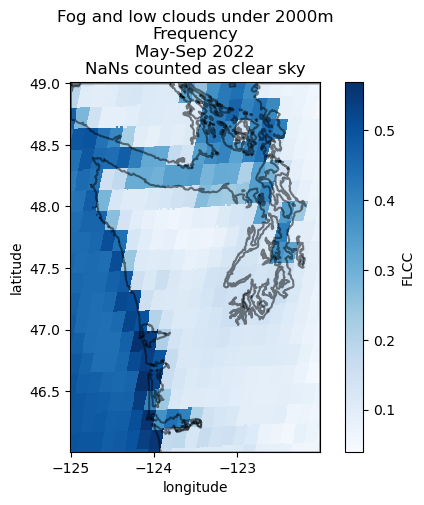

In [34]:
fig, ax = plt.subplots()

FLCC_freq.plot(ax = ax, cmap = 'Blues')
shoreline.plot(ax = ax, color = "black", alpha = 0.5) # how to make the stroke of the shoreline thinner?
plt.title('Fog and low clouds under 2000m\nFrequency\nMay-Sep 2022\nNaNs counted as clear sky')

### High clouds or Clear sky frequency (NaN not ignored)

In [29]:
# For calculating frequency of high clouds or clear sky
ds['High_or_Clear'] = (ds['Height'] > 2000).astype(int)
nan_indices = ds['Height'].isnull() # xarray's isnull() returns a boolean array indicated which item in ds['Height] has a missing value
'''Filter the array: keep the items that pass the condition. The items which don't pass will be replaced with NaNs.
This is xarray's where(), very different from numpy's where(). '''
not_nan_indices = ~nan_indices
ds['High_or_Clear'] = ds['High_or_Clear'].where(not_nan_indices, 1) # Change the False values in FLCC which were originally NaNs in Height to True in FLCC
highclear_freq = (
    ds['High_or_Clear'].sum(dim='time') / ds['time'].size
)

In [30]:
highclear_freq.load()

<xarray.DataArray 'High_or_Clear' (latitude: 284, longitude: 284)>
array([[0.83067304, 0.83067304, 0.83067304, ..., 0.94103224, 0.94103224,
        0.94103224],
       [0.83067304, 0.83067304, 0.83067304, ..., 0.94103224, 0.94103224,
        0.94103224],
       [0.83067304, 0.83067304, 0.83067304, ..., 0.94103224, 0.94103224,
        0.94103224],
       ...,
       [0.50454824, 0.50454824, 0.50454824, ..., 0.93764865, 0.93764865,
        0.93764865],
       [0.50454824, 0.50454824, 0.50454824, ..., 0.93764865, 0.93764865,
        0.93764865],
       [0.50454824, 0.50454824, 0.50454824, ..., 0.93764865, 0.93764865,
        0.93764865]])
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

Text(0.5, 1.0, 'High clouds or Clear sky (NaNs)\nFrequency\nMay-Sep 2022\n')

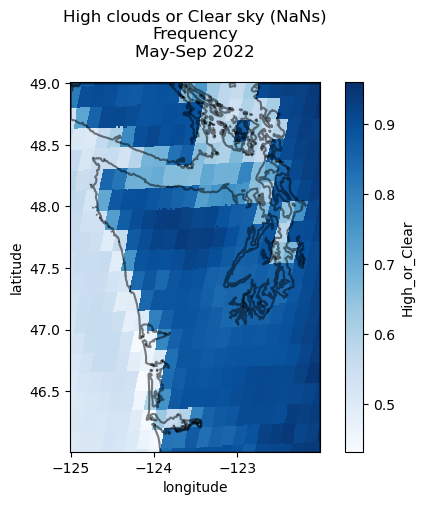

In [31]:
fig, ax = plt.subplots()

highclear_freq.plot(ax = ax, cmap = 'Blues')
shoreline.plot(ax = ax, color = "black", alpha = 0.5) # how to make the stroke of the shoreline thinner?
plt.title('High clouds or Clear sky (NaNs)\nFrequency\nMay-Sep 2022\n')

### Frequency during different times in a day

In [36]:
# documentation about indexing using datetime components: https://docs.xarray.dev/en/stable/user-guide/time-series.html#indexing-using-datetime-components
# Select images taken from 5am to the end of 9am for see fog frequency in the morning
morning_ds = ds.isel(time=ds.time.dt.hour.isin([5,6,7,8,9])) 
# Select images taken from 11am to the end of 12pm for see fog frequency during midday
midday_ds = ds.isel(time=ds.time.dt.hour.isin([11,12]))
# Select images taken from 1pm to the end of 5pm for see fog frequency in the afternoon
afternoon_ds = ds.isel(time=ds.time.dt.hour.isin([1,2,3,4,5]))

In [37]:
morning_freq = (
    morning_ds['FLCC'].sum(dim='time') / morning_ds['time'].size
)

In [38]:
morning_freq.load()

<xarray.DataArray 'FLCC' (latitude: 284, longitude: 284)>
array([[0.16507144, 0.16507144, 0.16507144, ..., 0.02843668, 0.02843668,
        0.02843668],
       [0.16507144, 0.16507144, 0.16507144, ..., 0.02843668, 0.02843668,
        0.02843668],
       [0.16507144, 0.16507144, 0.16507144, ..., 0.02843668, 0.02843668,
        0.02843668],
       ...,
       [0.53322236, 0.53322236, 0.53322236, ..., 0.04896657, 0.04896657,
        0.04896657],
       [0.53322236, 0.53322236, 0.53322236, ..., 0.04896657, 0.04896657,
        0.04896657],
       [0.53322236, 0.53322236, 0.53322236, ..., 0.04896657, 0.04896657,
        0.04896657]])
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

In [41]:
midday_freq = (
    midday_ds['FLCC'].sum(dim='time') / midday_ds['time'].size
)

In [42]:
midday_freq.load()

<xarray.DataArray 'FLCC' (latitude: 284, longitude: 284)>
array([[0.16703645, 0.16703645, 0.16703645, ..., 0.02091918, 0.02091918,
        0.02091918],
       [0.16703645, 0.16703645, 0.16703645, ..., 0.02091918, 0.02091918,
        0.02091918],
       [0.16703645, 0.16703645, 0.16703645, ..., 0.02091918, 0.02091918,
        0.02091918],
       ...,
       [0.52393027, 0.52393027, 0.52393027, ..., 0.04183835, 0.04183835,
        0.04183835],
       [0.52393027, 0.52393027, 0.52393027, ..., 0.04183835, 0.04183835,
        0.04183835],
       [0.52393027, 0.52393027, 0.52393027, ..., 0.04183835, 0.04183835,
        0.04183835]])
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

Text(0.5, 1.0, 'MIDDAY Fog and low clouds\nunder 2000m\nFrequency\nMay-Sep 2022\nNaNs counted as clear sky')

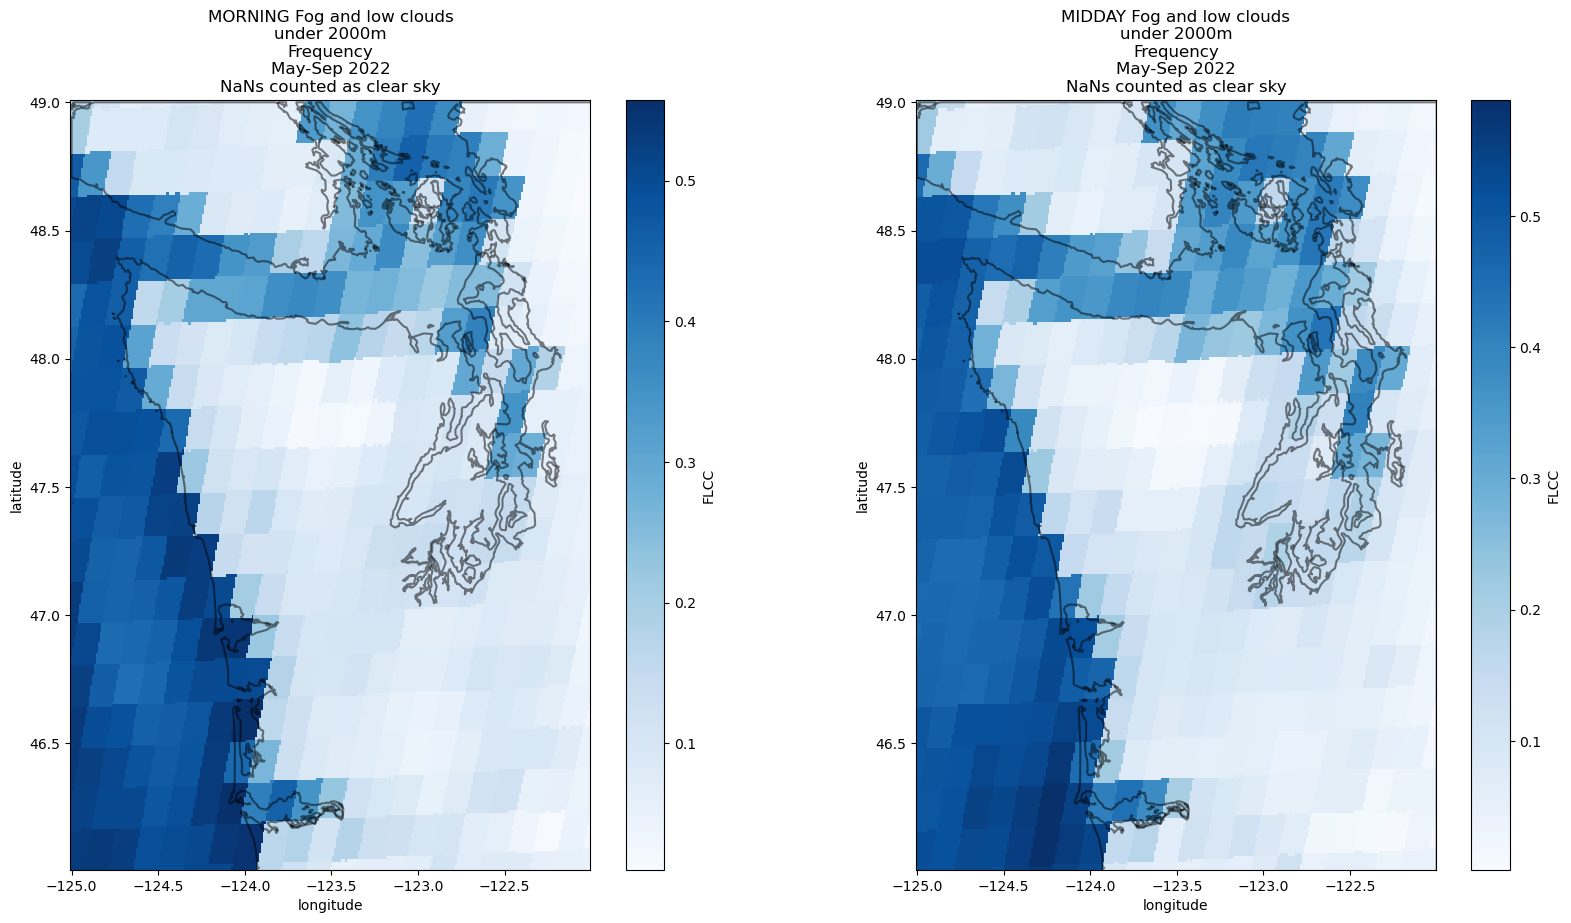

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

morning_freq.plot(ax = ax[0], cmap = 'Blues')
shoreline.plot(ax = ax[0], color = "black", alpha = 0.5) # how to make the stroke of the shoreline thinner?
ax[0].set_title('MORNING Fog and low clouds\nunder 2000m\nFrequency\nMay-Sep 2022\nNaNs counted as clear sky')

midday_freq.plot(ax = ax[1], cmap = 'Blues')
shoreline.plot(ax = ax[1], color = "black", alpha = 0.5)
ax[1].set_title('MIDDAY Fog and low clouds\nunder 2000m\nFrequency\nMay-Sep 2022\nNaNs counted as clear sky')

## NaN frequency

In [17]:
ds['nan'] = (ds['Height'].isnull())
nan_freq = (
    ds['nan'].sum(dim='time') / ds['time'].size
)

In [18]:
nan_freq.load()

<xarray.DataArray 'nan' (latitude: 284, longitude: 284)>
array([[0.28733603, 0.28733603, 0.28733603, ..., 0.34897634, 0.34897634,
        0.34897634],
       [0.28733603, 0.28733603, 0.28733603, ..., 0.34897634, 0.34897634,
        0.34897634],
       [0.28733603, 0.28733603, 0.28733603, ..., 0.34897634, 0.34897634,
        0.34897634],
       ...,
       [0.15081525, 0.15081525, 0.15081525, ..., 0.42616158, 0.42616158,
        0.42616158],
       [0.15081525, 0.15081525, 0.15081525, ..., 0.42616158, 0.42616158,
        0.42616158],
       [0.15081525, 0.15081525, 0.15081525, ..., 0.42616158, 0.42616158,
        0.42616158]])
Coordinates:
  * latitude   (latitude) float64 49.0 48.99 48.98 48.97 ... 46.03 46.02 46.01
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -122.0 -122.0 -122.0

Text(0.5, 1.0, 'NaN frequency\nMay-Sep 2022')

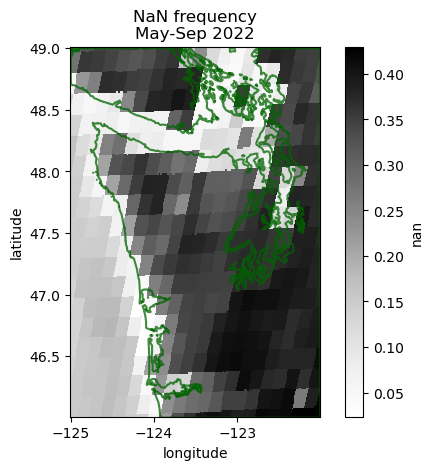

In [19]:
fig, ax = plt.subplots()

nan_freq.plot(ax = ax, cmap = 'Greys')
shoreline.plot(ax = ax, color = "darkgreen", alpha = 0.75) # how to make the stroke of the shoreline thinner?
plt.title('NaN frequency\nMay-Sep 2022')

### Let's look at the time series at a single point for a few days

In [ ]:
# Longitudes and Latitudes for all the field locations on San Juan Islands
pt1 = [48.50891,        -123.03491]
pt2 = [48.55745,        -123.0824]
pt3 = [48.52329,        -123.1371]
pt4 = [40.55423,        -122.36151]
pt5 = [48.46446,        -122.96222]
pt6 = [48.53304291, 	-123.0882645]
pt7 = [48.61820602, 	-123.1203384]
pt8 = [48.56717682, 	-123.1648407]
pt9 = [48.48910141, 	-123.0627441]
pt10 = [48.48910141, 	-123.0627441]
pt11 = [48.490756, 	    -123.067895]
pt12 = [48.57880161, 	-123.1731671]

In [41]:
falsebay_timeseries = ds['Height'].sel(latitude = 48.490914, longitude = -123.069227, method='nearest')

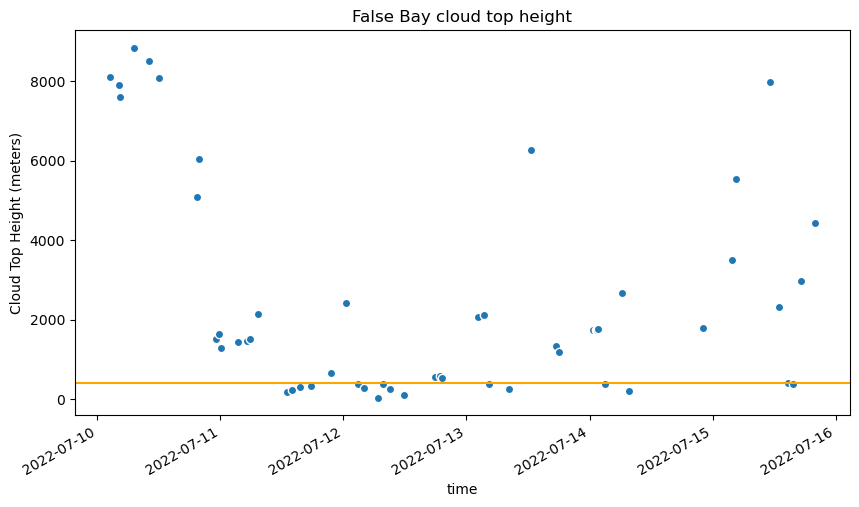

In [42]:
plt.figure(figsize = (10,5))
falsebay_timeseries.sel(time = slice('July 10, 2022', 'July 15, 2022')).plot.scatter('time')
plt.title('False Bay cloud top height')
plt.ylabel('Cloud Top Height (meters)')
plt.axhline(400, color='orange') # 400 meters is the chosen threshold for low cloud and fog

### Playground for me to experiment with xarray

In [ ]:
array = xr.DataArray([1, 2, np.nan, 4, np.nan], coords=[("x", [0.1, 0.2, 0.3, 0.4, 0.5])])
# array.isnull().sum()
# array.size
# array.sum()
array.isnull().sum().values

array(2)

In [ ]:
def func(x):
    return x<3

In [ ]:
xr.apply_ufunc(func, array)

<xarray.DataArray (x: 5)>
array([ True,  True, False, False, False])
Coordinates:
  * x        (x) float64 0.1 0.2 0.3 0.4 0.5

In [ ]:
def classify_fog(height):
    # if np.isnan(height):
    #     return np.nan
    # elif height < 400:
    #     return 1
    if height < 400:
        return 1
    else:
        return 0
    